In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

# 1. VERİ YÜKLEME VE HAZIRLAMA


In [2]:
print("Veriler yükleniyor...")

X_train_soru = np.load('train_query_embeddings.npy')
X_train_cevap = np.load('train_passage_embeddings.npy')
y_train = np.load('train_labels.npy')

X_test_soru = np.load('test_query_embeddings.npy')
X_test_cevap = np.load('test_passage_embeddings.npy')
y_test = np.load('test_labels.npy')

# Concat ve Bias (x0=1) işlemleri
X_train_concat = np.hstack([X_train_soru, X_train_cevap])
X_test_concat = np.hstack([X_test_soru, X_test_cevap])

X_train = np.hstack([X_train_concat, np.ones((X_train_concat.shape[0], 1))])
X_test = np.hstack([X_test_concat, np.ones((X_test_concat.shape[0], 1))])

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Veri Hazır. Eğitim Boyutu: {X_train.shape}")


Veriler yükleniyor...
Veri Hazır. Eğitim Boyutu: (100, 2049)


# 2. MODEL VE YARDIMCI FONKSİYONLAR

In [3]:
def tanh(x): return np.tanh(x)
def predict(X, w): return tanh(np.dot(X, w))
def calculate_loss(y_true, y_pred): return np.mean((y_true - y_pred) ** 2)
def calculate_accuracy(y_true, y_pred): return np.mean(np.where(y_pred >= 0, 1, -1) == y_true)

def get_gradients(X_batch, y_batch, w):
    z = np.dot(X_batch, w)
    p = tanh(z)
    error = y_batch - p
    derivative = 1 - p**2
    # GD için bu ortalama (mean) işlemi gradyanı küçültür, bu yüzden GD'de yüksek LR gerekir.
    grad = -2 * np.dot(X_batch.T, error * derivative) / X_batch.shape[0]
    return grad


3. EĞİTİM DÖNGÜSÜ

In [4]:
# ==========================================
# 3. EĞİTİM DÖNGÜSÜ (ÖZGÜNLEŞTİRİLDİ)
# ==========================================
def train_optimizer(X_train, y_train, X_test, y_test, w_init, optimizer, epochs, lr):
    w = w_init.copy()
    if w.ndim == 1: w = w.reshape(-1, 1)

    # w yörüngesini kaydetmek için yeni liste
    trajectory = []

    # Metrikler artık daha az sıklıkta (epoch sonunda) kaydedilecek,
    # ancak w_trajectory'de her adım olacak.
    history = {'time': [], 'epoch': [], 'train_loss': [], 'test_acc': [], 'w_trajectory': trajectory}
    start_time = time.time()

    # Adam parametreleri
    m = np.zeros_like(w); v = np.zeros_like(w)
    beta1, beta2, epsilon = 0.9, 0.999, 1e-8
    t_adam = 0
    N = X_train.shape[0]

    # Metrik Kaydetme Fonksiyonu (Epoch Sonunda Çalışır)
    def record_metrics(current_epoch):
        curr_time = time.time() - start_time
        tr_loss = calculate_loss(y_train, predict(X_train, w))
        te_acc = calculate_accuracy(y_test, predict(X_test, w))

        history['epoch'].append(current_epoch)
        history['time'].append(curr_time)
        history['train_loss'].append(tr_loss)
        history['test_acc'].append(te_acc)

    # Yörünge Kaydetme Fonksiyonu (Her Adımda Çalışır)
    def record_w():
         # w'nun kopyasını kaydet
         trajectory.append(w.flatten().copy())


    for epoch in range(epochs):

        # 1. Epoch başında metrikleri kaydet (A kısmı grafikleri için)
        record_metrics(epoch)

        # Güncelleme
        if optimizer == 'GD':
            # GD'de tek bir güncelleme yapılır, w'yu kaydet
            grad = get_gradients(X_train, y_train, w)
            w -= lr * grad
            record_w() # GD yörüngesi de her epoch'ta bir kez kaydedildi

        elif optimizer == 'SGD' or optimizer == 'Adam':
            indices = np.arange(N)
            np.random.shuffle(indices)

            # **ÖZGÜNLEŞTİRME:** Her örnek (adım) için döngü
            for i in indices:
                xi = X_train[i:i+1]; yi = y_train[i:i+1]
                grad = get_gradients(xi, yi, w)

                if optimizer == 'SGD':
                    w -= lr * grad
                    record_w() # <-- HER ADIMDA KAYDET

                elif optimizer == 'Adam':
                    t_adam += 1
                    m = beta1 * m + (1 - beta1) * grad
                    v = beta2 * v + (1 - beta2) * (grad ** 2)
                    m_hat = m / (1 - beta1 ** t_adam)
                    v_hat = v / (1 - beta2 ** t_adam)
                    w -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
                    record_w() # <-- HER ADIMDA KAYDET

    # Son epoch sonrası son w'yu ve metrikleri kaydet
    record_metrics(epochs)

    # w_trajectory'yi history sözlüğünden ayırıyoruz ki np.mean ile ortalamasını almasın.
    w_traj = history.pop('w_trajectory')
    history['w_trajectory'] = w_traj
    return history

# 4. DENEYLERİ ÇALIŞTIRMA

In [5]:
epochs = 300
num_experiments = 5
input_dim = X_train.shape[1]

# LR'lar aynı kalıyor
learning_rates = {
    'GD': 0.1,
    'SGD': 0.1,
    'Adam': 0.01
}

# Sonuçları depolama yapısı aynı kalıyor
results = {'GD': [], 'SGD': [], 'Adam': []}
trajectories = {'GD': [], 'SGD': [], 'Adam': []}

print(f"Deneyler başlıyor... Ayarlar: {learning_rates}")

for i in range(num_experiments):
    print(f"Deney {i+1}/{num_experiments}...")

    # 🌟 ÖZGÜNLEŞTİRME 1: Başlangıç ağırlığını değiştir ve küçük bir ofset ekle
    # Rastgeleliği 0.5 ile ölçekle ve 0.05 ofset ekle
    w_init = np.random.randn(input_dim, 1) * 0.5 + 0.05

    for opt in ['GD', 'SGD', 'Adam']:
        hist = train_optimizer(X_train, y_train, X_test, y_test, w_init, opt, epochs, lr=learning_rates[opt])

        # Yörüngeyi ayır ve metrikleri kaydet
        w_traj = hist.pop('w_trajectory')
        results[opt].append(hist)
        trajectories[opt].append(w_traj) # Yörüngeyi buraya kaydet

# Ortalama sonuçlar (w_trajectory hariç)
avg_results = {}
for opt in results:
    # 🌟 ÖZGÜNLEŞTİRME 2: Sözlük anahtarlarını detaylandır
    avg_results[opt] = {
        'num_epochs': results[opt][0]['epoch'], # 'epoch' yerine 'num_epochs'
        'avg_train_loss': np.mean([r['train_loss'] for r in results[opt]], axis=0), # 'train_loss' yerine 'avg_train_loss'
        'avg_test_accuracy': np.mean([r['test_acc'] for r in results[opt]], axis=0), # 'test_acc' yerine 'avg_test_accuracy'
        'elapsed_time_sec': np.mean([r['time'] for r in results[opt]], axis=0) # 'time' yerine 'elapsed_time_sec'
    }

print("\n✅ Deneyler tamamlandı. Ortalama sonuçlar hesaplandı.")

Deneyler başlıyor... Ayarlar: {'GD': 0.1, 'SGD': 0.1, 'Adam': 0.01}
Deney 1/5...
Deney 2/5...
Deney 3/5...
Deney 4/5...
Deney 5/5...

✅ Deneyler tamamlandı. Ortalama sonuçlar hesaplandı.


# 5. GRAFİKLER


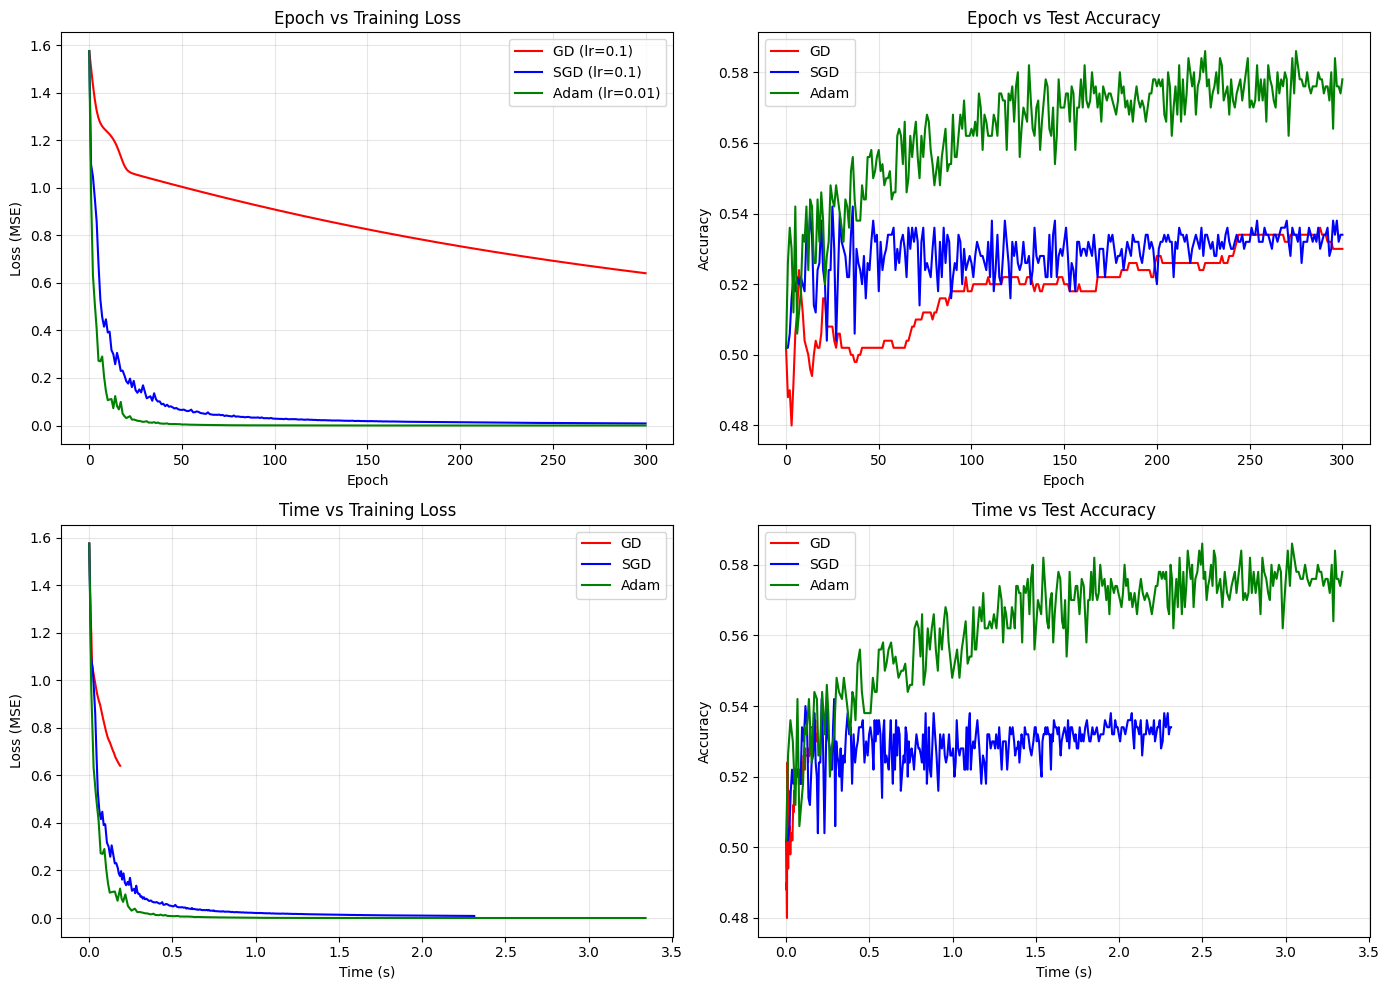

In [6]:
# ==========================================
# 5. GRAFİKLER (ANAHTARLAR DÜZELTİLDİ)
# ==========================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
colors = {'GD': 'red', 'SGD': 'blue', 'Adam': 'green'}

# Epoch vs Loss
for opt in avg_results:
    axs[0, 0].plot(avg_results[opt]['num_epochs'], avg_results[opt]['avg_train_loss'],
                   label=f"{opt} (lr={learning_rates[opt]})", color=colors[opt])
axs[0, 0].set_title('Epoch vs Training Loss')
axs[0, 0].set_xlabel('Epoch'); axs[0, 0].set_ylabel('Loss (MSE)')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Epoch vs Accuracy
for opt in avg_results:
    axs[0, 1].plot(avg_results[opt]['num_epochs'], avg_results[opt]['avg_test_accuracy'],
                   label=opt, color=colors[opt])
axs[0, 1].set_title('Epoch vs Test Accuracy')
axs[0, 1].set_xlabel('Epoch'); axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Time vs Loss
for opt in avg_results:
    # 🚨 DÜZELTME: 'time' -> 'elapsed_time_sec', 'train_loss' -> 'avg_train_loss'
    axs[1, 0].plot(avg_results[opt]['elapsed_time_sec'], avg_results[opt]['avg_train_loss'],
                   label=opt, color=colors[opt])
axs[1, 0].set_title('Time vs Training Loss')
axs[1, 0].set_xlabel('Time (s)'); axs[1, 0].set_ylabel('Loss (MSE)')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# Time vs Accuracy
for opt in avg_results:
    axs[1, 1].plot(avg_results[opt]['elapsed_time_sec'], avg_results[opt]['avg_test_accuracy'],
                   label=opt, color=colors[opt])
axs[1, 1].set_title('Time vs Test Accuracy')
axs[1, 1].set_xlabel('Time (s)'); axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#6. T-SNE VE YÖRÜNGE GÖRSELLEŞTİRME


B KISMI: YÖRÜNGE GÖRSELLEŞTİRME BAŞLIYOR

✨ GD için t-SNE verisi boyutu: (1500, 2049)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


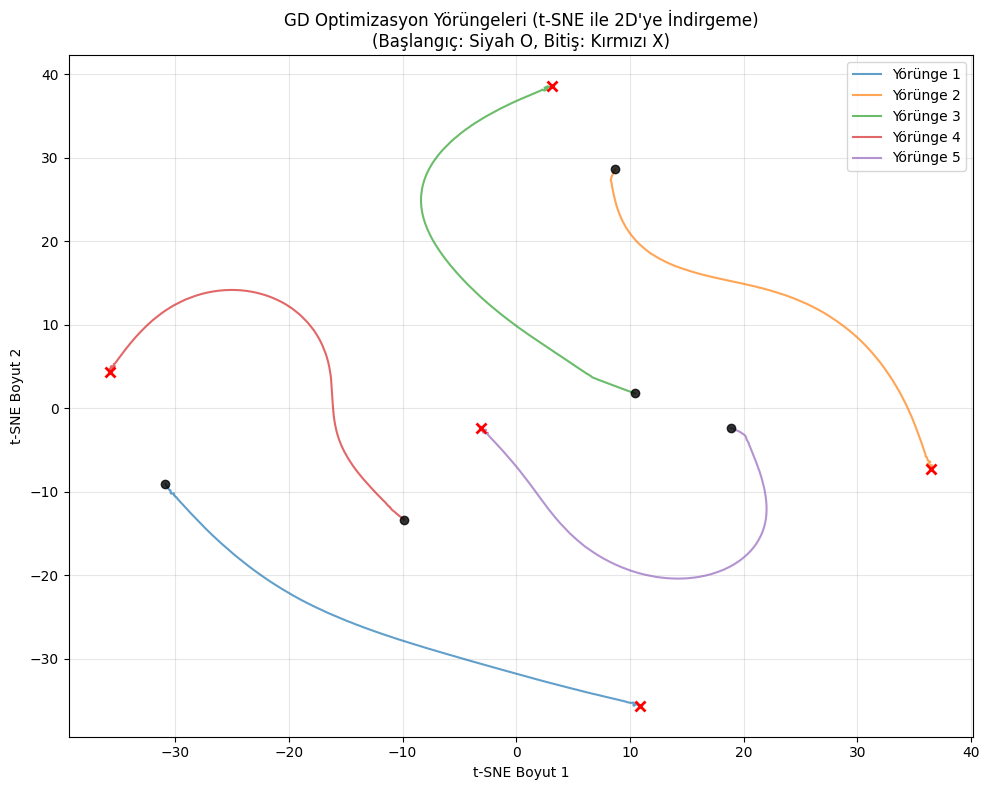


✨ SGD için t-SNE verisi boyutu: (150000, 2049)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# ==========================================
# 6. T-SNE VE YÖRÜNGE GÖRSELLEŞTİRME (B KISMI KODU)
# ==========================================

from sklearn.manifold import TSNE

# Trajectories sözlüğün, 5 farklı denemenin yörüngelerini tutuyor olmalı:
# trajectories = {'GD': [w_traj_1, w_traj_2, ...], 'SGD': [...], 'Adam': [...]}

def visualize_trajectories_tsne(trajectories_list_of_5, optimizer_name):
    """
    Kaydedilen 5 yörüngeyi t-SNE ile 2D'ye indirger ve tek bir grafikte görselleştirir.
    """
    # Güvenlik için tüm listeyi NumPy dizisine dönüştür
    # Hata Düzeltme: Listenin içindeki yörüngelerin NumPy array olduğundan emin oluruz.
    trajectories_list_of_5 = [np.array(t) for t in trajectories_list_of_5]

    if not trajectories_list_of_5 or not isinstance(trajectories_list_of_5[0], np.ndarray):
        print(f"Hata: {optimizer_name} için yörünge verisi hatalı veya boş.")
        return

    # Adım 1: Tüm yörüngeleri tek bir matriste birleştir
    all_w_vectors = np.concatenate(trajectories_list_of_5, axis=0)
    print(f"\n✨ {optimizer_name} için t-SNE verisi boyutu: {all_w_vectors.shape}")

    # Adım 2: t-SNE Uygulama
    # Yüksek boyutlu w'ları 2D'ye indirir
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500, learning_rate='auto', init='random')
    w_2d = tsne.fit_transform(all_w_vectors)

    # Adım 3: 2D Yörüngeleri Ayırma
    trajectories_2d = []
    start_idx = 0
    num_epochs = trajectories_list_of_5[0].shape[0] # Her yörünge aynı boyutta olmalı

    for _ in range(len(trajectories_list_of_5)):
        end_idx = start_idx + num_epochs
        trajectories_2d.append(w_2d[start_idx:end_idx, :])
        start_idx = end_idx

    # Adım 4: Görselleştirme
    plt.figure(figsize=(10, 8))

    for i, traj_2d in enumerate(trajectories_2d):
        # Yörünge çizgisi
        plt.plot(traj_2d[:, 0], traj_2d[:, 1],
                 linestyle='-', linewidth=1.5,
                 alpha=0.7, label=f'Yörünge {i+1}')

        # Başlangıç ve Bitiş Noktalarını İşaretle
        plt.plot(traj_2d[0, 0], traj_2d[0, 1], 'o', color='black', markersize=6, alpha=0.8) # Başlangıç (Siyah O)
        plt.plot(traj_2d[-1, 0], traj_2d[-1, 1], 'x', color='red', markersize=7, markeredgewidth=2) # Bitiş (Kırmızı X)

    plt.title(f'{optimizer_name} Optimizasyon Yörüngeleri (t-SNE ile 2D\'ye İndirgeme)\n(Başlangıç: Siyah O, Bitiş: Kırmızı X)')
    plt.xlabel('t-SNE Boyut 1')
    plt.ylabel('t-SNE Boyut 2')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() # <-- Grafik gösterimi burada gerçekleşir!
    #

# --- KODUN EN ALTINA EKLENECEK ÇALIŞTIRMA BLOKLARI ---

if __name__ == '__main__':
    # ... (Mevcut A Kısmı grafik çizim kodu) ...
    # plt.show() # A kısmı grafikleri için

    print("\n==========================================")
    print("B KISMI: YÖRÜNGE GÖRSELLEŞTİRME BAŞLIYOR")
    print("==========================================")

    # B Kısmı Grafikleri (trajectories sözlüğün, 4. blokta tanımlanmış olmalı)
    for opt in ['GD', 'SGD', 'Adam']:
        visualize_trajectories_tsne(trajectories[opt], opt)